In [1]:
!sudo pip install -q "monai-weekly[nibabel, tqdm, einops]"
!sudo python3 -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/exouser/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.5.3
einops version: 0.6.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/i

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [4]:
images_dir = '/home/exouser/Documents/Task500_AMOS/imagesTr/'
labels_dir = '/home/exouser/Documents/Task500_AMOS/labelsTr/'
import json
# Get list of image file paths
image_files = [os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.nii.gz')]

# Get list of label file paths
label_files = [os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.nii.gz')]

# Create list of dictionaries with image and label file paths
files = []
for image_file, label_file in zip(image_files, label_files):
    item = {"image": image_file, "label": label_file}
    files.append(item)

# Print out the resulting list of dictionaries
# print(true_val_files)
# Serializing json
json_object = json.dumps(files, indent=4)
 
# Writing to sample.json
with open("dataset.json", "w") as outfile:
    outfile.write(json_object)

In [5]:
import re
import json

# Define a function to extract the last digits from a string
def extract_last_digits(s):
    return int(re.findall('\d+', s)[-1])

# Load the JSON data from file
with open('dataset.json', 'r') as f:
    json_data = json.load(f)

# Sort the JSON array by the last digits in the "image" field
json_data_sorted = sorted(json_data, key=lambda x: extract_last_digits(x["image"]))

# Write the sorted JSON data back to file
with open('dataset_sorted.json', 'w') as f:
    json.dump(json_data_sorted, f, indent=4)

In [6]:
import json

# Load the sorted JSON data from file
with open('dataset_sorted.json', 'r') as f:
    json_data_sorted = json.load(f)

# Split the JSON data into training and validation sets
json_data_train = []
json_data_val = []
for item in json_data_sorted:
    image_num = int(item["image"].split("/")[-1].split("_")[-1].split(".")[0])
    if image_num <= 410:
        if image_num < 217:
            json_data_train.append(item)
        else:
            json_data_val.append(item)

# Combine the training and validation JSON data
json_data_combined = {"training": json_data_train, "validation": json_data_val}

# Write the combined JSON data to file
with open('dataset_combined.json', 'w') as f:
    json.dump(json_data_combined, f, indent=4)

In [7]:
data_dir = "Task500_AMOS/"
split_json = "dataset_combined.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|████████████████████████████| 6/6 [00:10<00:00,  1.75s/it]


In [8]:
val_images_dir = '/home/exouser/Documents/Task500_AMOS/validation_gt_im/'
val_labels_dir = '/home/exouser/Documents/Task500_AMOS/validation_gt_lb/'
import json
# Get list of image file paths
image_files = [os.path.join(val_images_dir, f) for f in os.listdir(val_images_dir) if f.endswith('.nii.gz')]

# Get list of label file paths
label_files = [os.path.join(val_labels_dir, f) for f in os.listdir(val_labels_dir) if f.endswith('.nii.gz')]

# Create list of dictionaries with image and label file paths
true_val_files = []
for image_file, label_file in zip(image_files, label_files):
    item = {"image": image_file, "label": label_file}
    true_val_files.append(item)

# Print out the resulting list of dictionaries
# print(true_val_files)
# Serializing json
json_object = json.dumps(true_val_files, indent=4)
 
# Writing to sample.json
with open("sample.json", "w") as outfile:
    outfile.write(json_object)

In [9]:
true_val_ds = CacheDataset(data=true_val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
true_val_loader = DataLoader(true_val_ds, shuffle=False, num_workers=4, pin_memory=True)
print(true_val_ds)

Loading dataset: 100%|██████████████████████████| 32/32 [00:11<00:00,  2.85it/s]

image shape: torch.Size([1, 225, 225, 202]), label shape: torch.Size([1, 225, 225, 202])


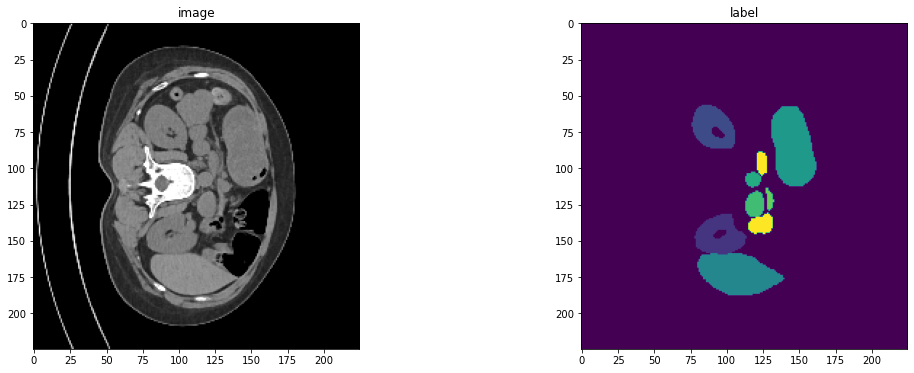

In [10]:
# size = (64, 64, 64)
slice_map = {
    "amos_0217.nii.gz": 170,
    "amos_0224.nii.gz": 118,
    "amos_0225.nii.gz": 190,
    "amos_0226.nii.gz": 180,
    "amos_0230.nii.gz": 130,
    "amos_0231.nii.gz": 204,
    "amos_0235.nii.gz": 204,
    "amos_0237.nii.gz": 180,
}
case_num = 4
img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [11]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [12]:
root_dir = ''
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description("Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss))
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_new.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best


max_iterations = 30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_new.pth")))

Training (1 / 30000 Steps) (loss=3.60672):   2%| | 2/122 [00:12<10:16,  5.14s/it../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [4068,0,0], thread: [10,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [4068,0,0], thread: [11,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [3942,0,0], thread: [39,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [3942,0,0], thread: [40,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [3942,0,0], thread: [41,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bo

Training (1 / 30000 Steps) (loss=3.60672):   2%| | 2/122 [00:16<16:37,  8.31s/it


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
case_num = 14

slice_map = {
    "amos_0507.nii.gz": 170,
    "amos_0508.nii.gz": 118,
    "amos_0510.nii.gz": 190,
    "amos_0514.nii.gz": 180,
    "amos_0522.nii.gz": 100,
    "amos_0530.nii.gz": 204,
    "amos_0532.nii.gz": 204,
    "amos_0538.nii.gz": 180,
}
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(true_val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = true_val_ds[case_num]["image"]
    label = true_val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    print(f"image shape: {img_shape}, label shape: {label_shape}")
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from skimage.transform import resize

def dice_coefficient(y_pred, y_true):
    if np.sum(y_true) == 0:
        return np.nan
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    intersection = np.sum(y_pred * y_true)
    return (2. * intersection) / (np.sum(y_pred) + np.sum(y_true))

In [ ]:
# Set the directory containing the validation images
validation_dir = "/home/exouser/Documents/Task500_AMOS/validation_gt_im/"

# Set the path to the ground truth label file
gt_label_dir = "/home/exouser/Documents/Task500_AMOS/validation_gt_lb/"

# Set the path to the model file
model_path = os.path.join(root_dir, "best_metric_model.pth")

In [ ]:
for case_num in range(len(os.listdir(validation_dir))):
    f_name = 'predictions/prediction_' + str(case_num) + '.npy'
    if not os.path.exists(f_name):
        with torch.no_grad():
            img_name = os.path.split(true_val_ds[case_num]["image"].meta["filename_or_obj"])[1]
            img = true_val_ds[case_num]["image"]
            label = true_val_ds[case_num]["label"]
            val_inputs = torch.unsqueeze(img, 1).cuda()
            val_labels = torch.unsqueeze(label, 1).cuda()
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)

        pred_lbl = torch.argmax(val_outputs, dim=1).detach().cpu().numpy()
        pred_arr = np.zeros(true_val_ds[case_num]["label"].meta["dim"][1:4])
        for i in range(14):
            if i == 0:
                continue
            lbl_tmp = resize(pred_lbl[0, ...] == i, true_val_ds[case_num]["label"].meta["dim"][1:4], order=0) > 0 
            pred_arr[np.where(lbl_tmp)] = i

        np.save(f_name, pred_arr)
    else:
        pred_arr = np.load(f_name)
        
    lbl = nib.load(true_val_ds[case_num]["label"].meta["filename_or_obj"])
    lbl_arr = lbl.get_fdata()

    orientation = nib.aff2axcodes(lbl.affine)
#     print(orientation)
    for orient, truth, ax in zip(orientation, ['R', 'A', 'S'], [0, 1, 2]): 
        if orient != truth:
            lbl_arr = np.flip(lbl_arr, axis=ax)


    for i in range(14):
        if i == 0:
            continue
        dice_score = dice_coefficient(pred_arr == i, lbl_arr == i)
        if np.isnan(dice_score):
            print('case_num: ' + str(case_num) + ' roi: ' + str(i) + ' not in field of view!')
        else:
            print('case_num: ' + str(case_num) + ' roi: ' + str(i) + ' dsc: ' + str(dice_score))

In [ ]:
## for nnUnet

lbl = nib.load(val_ds[case_num]["label"].meta["filename_or_obj"])
lbl_arr = lbl.get_fdata()

pred = nib.load("corresponding nnUnet filePath")
pred_arr = lbl.get_fdata()


for i in range(14):
    if i == 0:
        continue
    dice_score = dice_coefficient(pred_arr == i, lbl_arr == i)
    print('case_num: ' + str(case_num) + ' dsc: ' + str(dice_score))

In [ ]:
case_num = 9
with torch.no_grad():
    img_name = os.path.split(true_val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = true_val_ds[case_num]["image"]
    label = true_val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 70], cmap="gray")

In [ ]:
lbl_nf = nib.load(val_ds[case_num]["label"].meta["filename_or_obj"])

In [ ]:
nib.aff2axcodes(lbl_nf.affine)

In [ ]:
lbl = nib.load(val_ds[case_num]["label"].meta["filename_or_obj"])
lbl_arr = lbl.get_fdata()

orientation = nib.aff2axcodes(lbl.affine)


In [ ]:
orientation[0]